# Computational Game Theory Group Assignment: Evolutionary Dynamics  of N-person Hawk-Dove games
Sam Vanspringel - 0580462 - VUB

Hendrik Temmerman - 0568045 - VUB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import egttools as egt
import nashpy as nash
import scipy

from scipy.special import comb

from egttools.plotting.helpers import (
    xy_to_barycentric_coordinates, calculate_stationary_points, calculate_stability
)
from egttools.helpers.vectorized import (
    vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates
)

from egttools.plotting import Simplex2D

from egttools.analytical import replicator_equation_n_player
from egttools.analytical.utils import (calculate_gradients, find_roots, check_replicator_stability_pairwise_games,)
from egttools.plotting import plot_gradients
from pprint import pprint

In [32]:
# jgklfdsjfd

# 1. Infinite Populations

In [13]:
# define the parameters
R = 1.0
N = 5

#n_hawks = np.random.randint(0, N)
#n_doves = N - n_hawks

#x_hawks = n_hawks/N
#x_doves = 1-x_hawks

n_steps = 100

In [15]:
# Payoff hawks
def P_H(amount_hawks, c_h):
    P_H = 0
    total_hawks = amount_hawks + 1
    if total_hawks > 0:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

# Payoff doves
def P_D(amount_hawks):
    if amount_hawks == 0:
        P_D = R/N
    elif amount_hawks > 0:
        P_D = 0.0
    return P_D

In [11]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H(i, c_h)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D(i+1)
    return average_fitness

# Fitness average
def average_fitness_population(x_hawks, x_doves, fitness_hawks, fitness_doves):
    return (x_hawks * fitness_hawks) + (x_doves * fitness_doves)
    


In [36]:
#Experiment (Figure: 1.A)

c_h_results = np.empty((3, n_steps))
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)    

for index, c_h in enumerate([0.1, 0.5, 0.9]):
    
    x_dot = np.empty(n_steps)

    for i in range(len(hawk_cost)):
        x = hawk_cost[i]
        fitness_doves = average_fitness_doves(N, x)
        fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

        x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)
        
    c_h_results[index] = x_dot


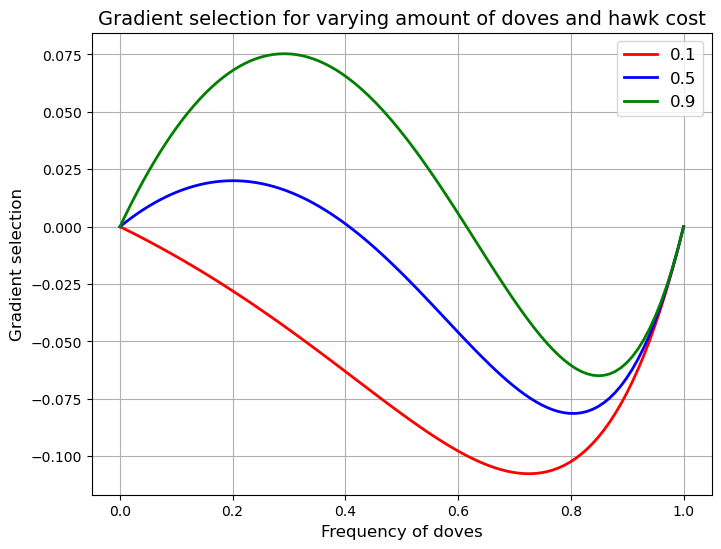

In [37]:
#Plotting
labels = ["0.1", "0.5", "0.9"]
colors = ["red", "blue", "green"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(c_h_results):
    plt.plot(hawk_cost, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [16]:
import statistics

def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq   
  
n_steps = 1000
dove_fractions = np.linspace(0, 1, num=n_steps, dtype=np.float64)
N_values = [5,10,20,50,100]
eq_results =  np.empty((len(N_values), n_steps))
PRECISION = 0.001

for i_N, N in enumerate(N_values):
    equilibria_N = []
    for index, c_h in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        eq_fraction = []
        x_dot = np.empty(n_steps)

        for i in range(len(dove_fractions)):
            x = dove_fractions[i]
            fitness_doves = average_fitness_doves(N, x)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h)

            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

            if abs(fitness_doves - fitness_hawks) < PRECISION:
                eq_fraction.append(x)
                if x != 0.0:
                     break

        if 0 in eq_fraction:
            eq_fraction.remove(0)
        if (n_steps - 1) in eq_fraction:
            eq_fraction.remove((n_steps - 1))
        if eq_fraction:
            equilibria_N.append(statistics.median(eq_fraction))
        else:
             equilibria_N.append(np.nan)      

    eq_results[i_N] = equilibria_N

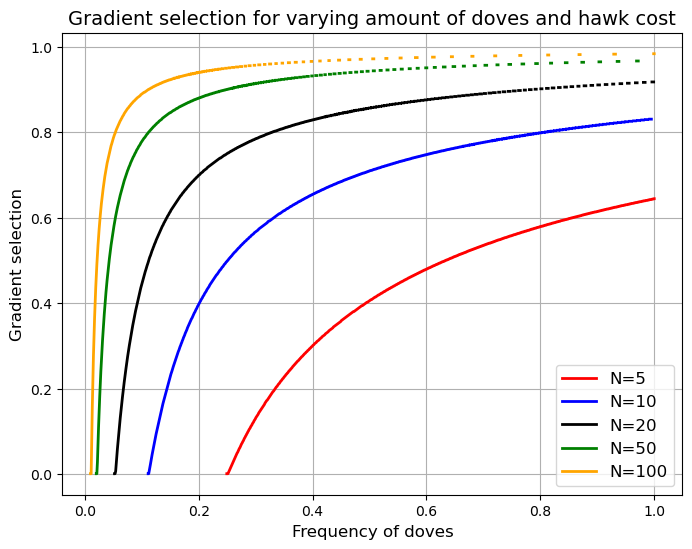

In [9]:

#Plotting
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]

# Plot each array
plt.figure(figsize=(8, 6))
for i, values in enumerate(eq_results):
    y = np.linspace(0, 1, num=len(values), dtype=np.float64)
    plt.plot(y, values, label=labels[i], color=colors[i], linewidth=2)

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [11]:
# Parameters
R = 1  
N = 5
c_H_values = [0.1, 0.5]  
Z_values = [10, 20, 100]  
w = 1  

In [12]:
def gradient_of_selection(k, Z, c_H, N, w):

    fraction = k/Z
    f_d = average_fitness_doves(N, fraction)
    f_h = average_fitness_hawks(N, (1-fraction), c_H)

    T_plus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_d - f_h))))
    T_minus = fraction * ((Z - k) / Z) * (1 / (1 + np.exp(-w * (f_h - f_d))))

    gradient = T_plus - T_minus
    return gradient

def calculate_gradients_figure_2A(Z, c_H, N, w):
    
    k_values = np.arange(Z + 1)
    g_values = np.empty(len(k_values))
    
    for i, k in enumerate(k_values):
        g_values[i] = gradient_of_selection(k, Z, c_H, N, w)

    X_as = k_values / Z
    
    return X_as, g_values

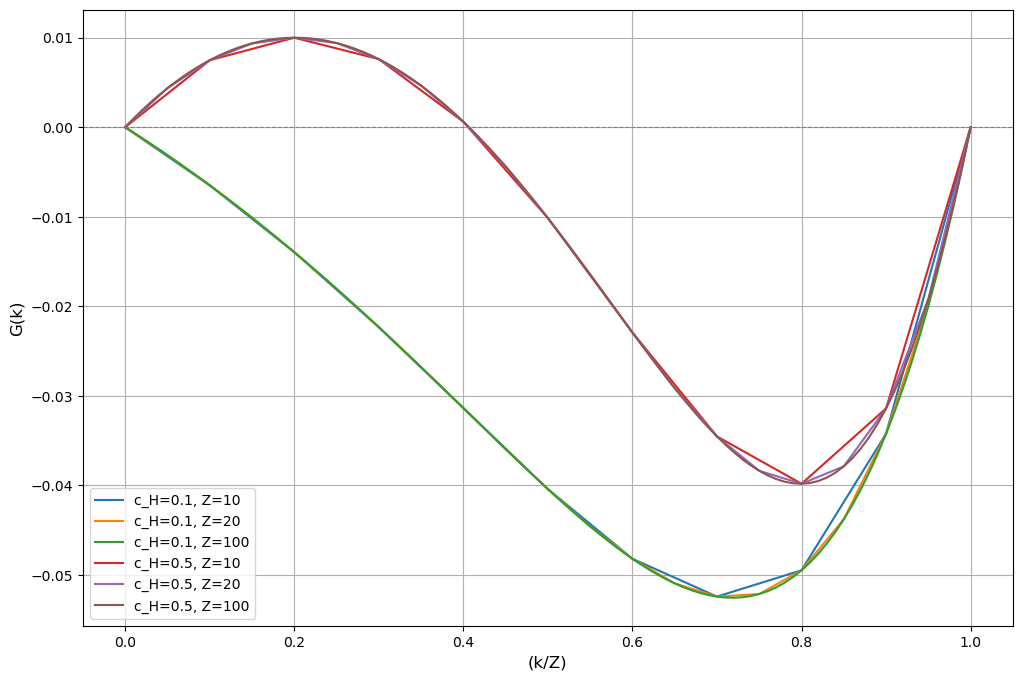

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

for c_H in c_H_values:
    for Z in Z_values:
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        ax.plot(X_as, g_values, label=f"c_H={c_H}, Z={Z}")

# Plot details
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlabel("(k/Z)", fontsize=12)
ax.set_ylabel("G(k)", fontsize=12)
ax.legend()
ax.grid()
plt.show()

In [14]:
Z = 100
R = 1
w = 1
hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
n_steps = 100

In [15]:
def calculate_gradients_figure_2B(Z, N, w):
    eq = []
    for index, c_H in enumerate(np.linspace(0, 1, num=n_steps, dtype=np.float64)):
        X_as, g_values = calculate_gradients_figure_2A(Z, c_H, N, w)
        
        equilibria = find_equilibria_indexes(g_values)  
        
        if len(equilibria) > 2:
            eq.append(hawk_cost[equilibria[1]])
        else: 
            eq.append(hawk_cost[equilibria[0]])

    return eq

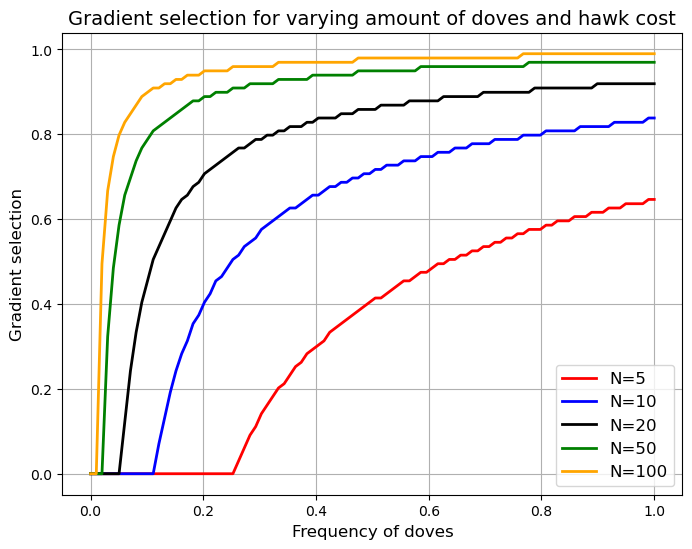

In [16]:
#Plotting
labels = ["N=5", "N=10", "N=20", "N=50", "N=100"]
colors = ["red", "blue", "black", "green", "orange"]
N_values = [5,10,20,50,100]


# Plot each array
plt.figure(figsize=(8, 6))
for i, N in enumerate(N_values):
    values = calculate_gradients_figure_2B(Z, N, w)
    plt.plot(hawk_cost, values, label=labels[i], color=colors[i], linewidth=2)

  

# Add labels, legend, and grid
plt.xlabel("Frequency of doves", fontsize=12)
plt.ylabel("Gradient selection", fontsize=12)
plt.title("Gradient selection for varying amount of doves and hawk cost", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

# Figure 3

In [2]:
# Parameters
N = 5
R = 1.0
n_steps = 100

In [3]:
# Payoff hawks
def P_H_T(amount_hawks, c_h, T, N):
    P_H = 0
    total_hawks= amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves/N < T:
        P_H = (R - (amount_hawks*c_h)) / total_hawks 
    return P_H

# Payoff doves
def P_D_T(amount_hawks, c_d,  T, N):
    P_D = 0
    total_hawks = amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves/N >= T:
        P_D = (R - (total_hawks * c_d)) / amount_doves
    return P_D

In [4]:
# Fitness hawks
def average_fitness_hawks(N, x_fraction, c_h, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_H_T(i, c_h, T, N)
    return average_fitness
    
# Fitness doves
def average_fitness_doves(N, x_fraction, c_d, T):
    average_fitness = 0.0
    for i in range(N):
        average_fitness += comb(N-1, i)*(x_fraction**i)*((1-x_fraction)**(N-1-i))*P_D_T(i, c_d, T, N)
    return average_fitness

In [5]:
def find_equilibria_indexes(run):
    eq = []
    for i in range(run.shape[0]):
        gradient = run[i]
        if gradient == 0.0:
            eq.append(i)
        if i < len(run):
            if run[i] < 0 and run[i + 1] > 0:
                    eq.append(i)
            if run[i] > 0 and run[i + 1] < 0:
                    eq.append(i)
    return eq

In [6]:
def figure3A(T, c_d):

    hawk_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    hawk_cost_answer = []


    for index, c_h in enumerate(hawk_cost):
        
        x_dot = np.empty(n_steps)

        for i in range(len(dove_frequency)):
            x = dove_frequency[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = x * (1 - x) * (fitness_hawks - fitness_doves)

        equilibria = find_equilibria_indexes(x_dot) 
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        hawk_cost_answer.extend([c_h] * len(equilibria))

    return fraction_dove, hawk_cost_answer


def figure3B(T, c_h):

    dove_cost = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    dove_frequency = np.linspace(0, 1, num=n_steps, dtype=np.float64)
    fraction_dove = []
    fraction_dove_answer = []

    for index, c_d in enumerate(dove_cost):
        
        x_dot =  np.empty(n_steps)

        for i in range(len(dove_frequency)):
            x = dove_frequency[i]
            fitness_doves = average_fitness_doves(N, x, c_d, T)
            fitness_hawks = average_fitness_hawks(N, 1-x, c_h, T)
            x_dot[i] = x*(1-x)*(fitness_doves - fitness_hawks)

        equilibria = find_equilibria_indexes(x_dot) 
        fraction_dove.extend([dove_frequency[equilibrium] for equilibrium in equilibria])
        fraction_dove_answer.extend([c_d] * len(equilibria))

    return fraction_dove, fraction_dove_answer

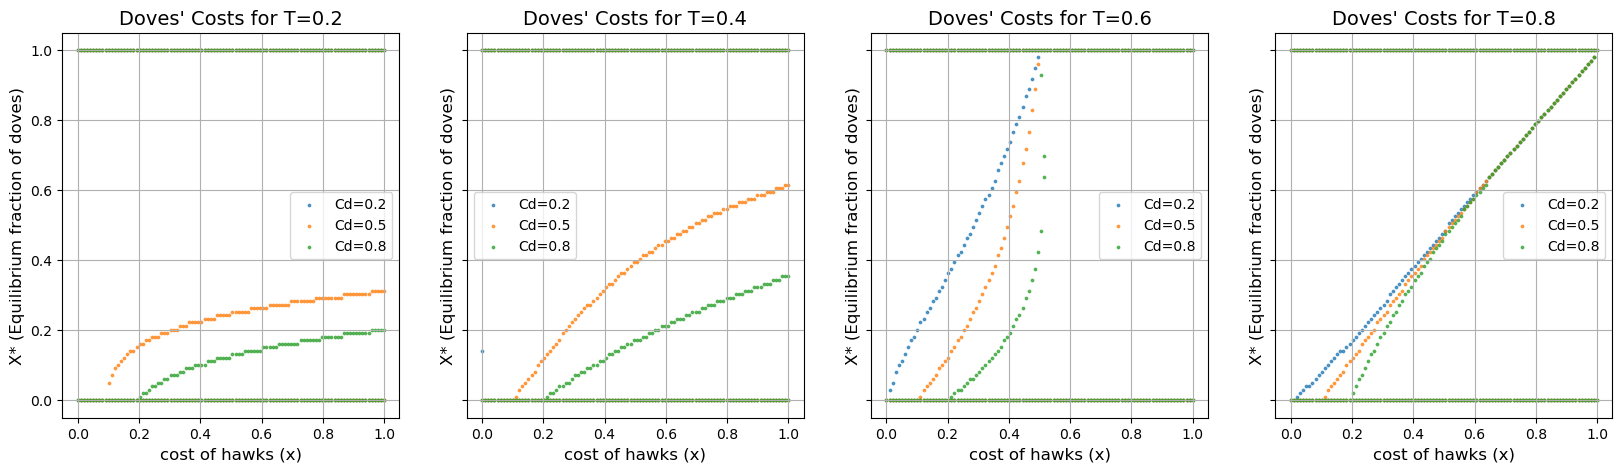

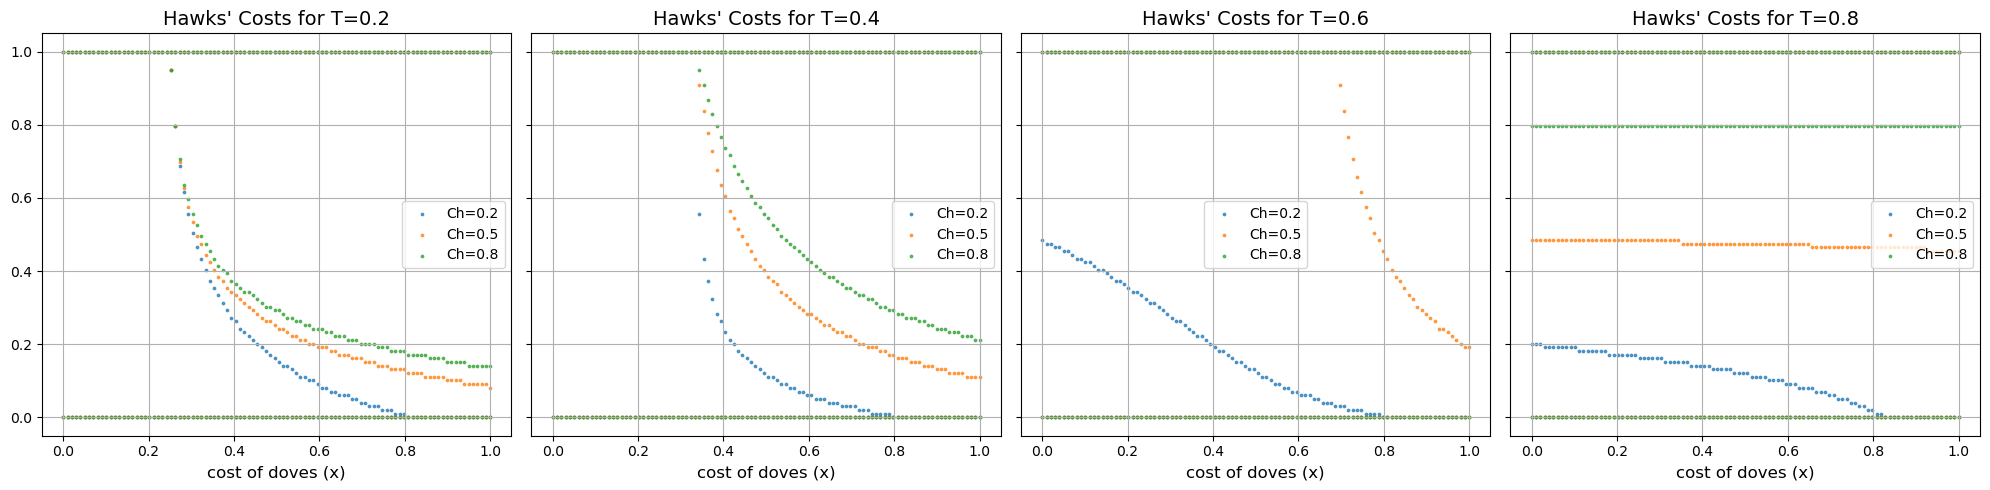

In [7]:
T_labels = ["T=0.2", "T=0.4", "T=0.6", "T=0.8"]
T_values = [0.2, 0.4, 0.6, 0.8]

Doves_Costs_labels = ["Cd=0.2", "Cd=0.5", "Cd=0.8"]
Doves_Costs = [0.2, 0.5, 0.8]

Hawks_Costs_labels = ["Ch=0.2", "Ch=0.5", "Ch=0.8"]
Hawks_Costs = [0.2, 0.5, 0.8]

def plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels):
    

    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):
        

        #Doves
        for d_idx, c_d in enumerate(Doves_Costs):
            y_as, x_as = figure3A(T, c_d)
            axes[t_idx].scatter(x_as, y_as, label=Doves_Costs_labels[d_idx], alpha =0.7, s=3)
            
        axes[t_idx].set_title(f"Doves' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of hawks (x)", fontsize=12)
        axes[t_idx].set_ylabel("X* (Equilibrium fraction of doves)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True) 


    fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)
    for t_idx, T in enumerate(T_values):
        for h_idx, c_h in enumerate(Hawks_Costs):
            y_as, x_as = figure3B(T, c_h)  
            axes[t_idx].scatter(x_as, y_as, label=Hawks_Costs_labels[h_idx], alpha =0.7, s=3)

        axes[t_idx].set_title(f"Hawks' Costs for {T_labels[t_idx]}", fontsize=14)
        axes[t_idx].set_xlabel("cost of doves (x)", fontsize=12)
        axes[t_idx].legend(fontsize=10, loc="best")
        axes[t_idx].grid(True)    

    plt.tight_layout()
    plt.show()

plot_figure3_side_by_side(T_values, Doves_Costs, Doves_Costs_labels, Hawks_Costs, Hawks_Costs_labels)

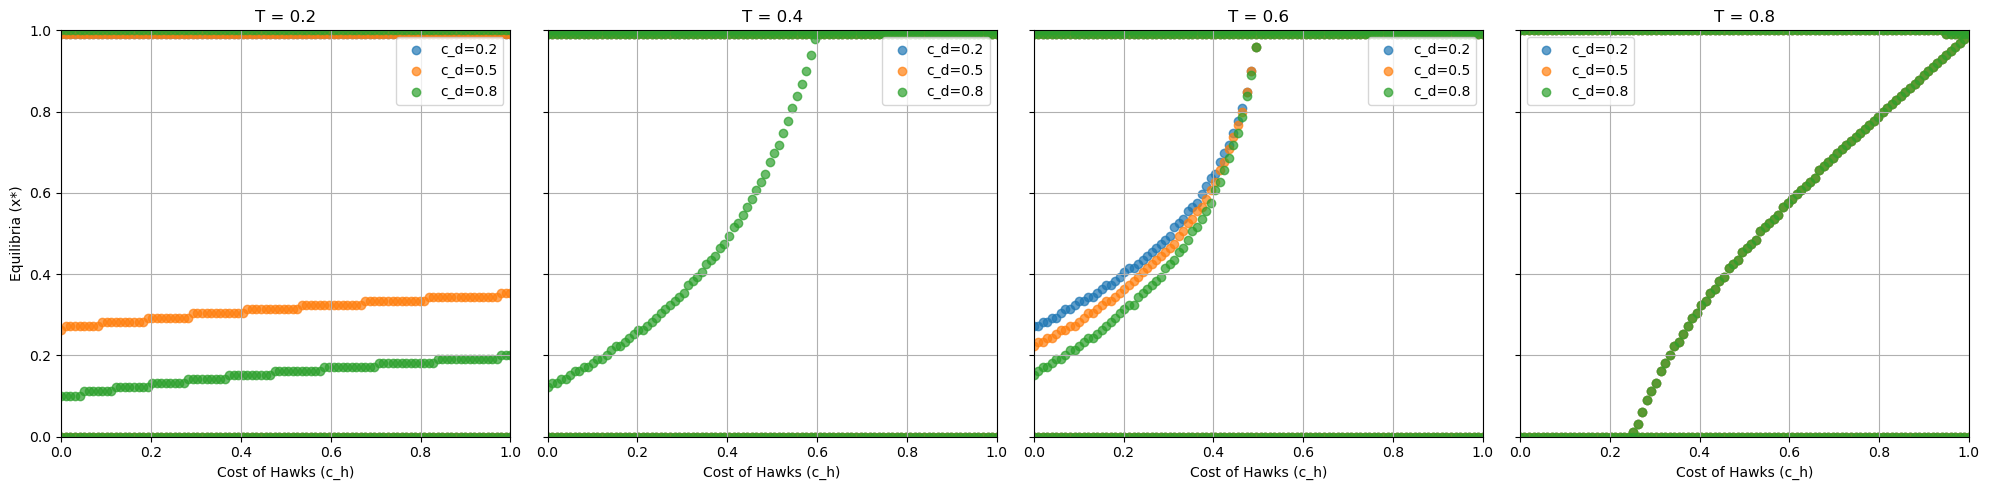

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb

# ------------------------------------------------------------------
# First, define your payoff and fitness functions
R = 1.0  # The paper uses R=1 by default

def P_H_T(amount_hawks, c_h, T, N):
    P_H = 0
    total_hawks = amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves / N < T:
        P_H = (R - amount_hawks*c_h) / total_hawks
    return P_H

def P_D_T(amount_hawks, c_d, T, N):
    P_D = 0
    total_hawks = amount_hawks + 1
    amount_doves = N - total_hawks
    if amount_doves / N >= T:
        P_D = R - (total_hawks * c_d) / amount_doves
    return P_D

def average_fitness_hawks_T(N, x_fraction, c_h, T):
    average_fitness = 0.0
    # Probability that exactly i of the other (N-1) are H => comb(N-1,i)*...
    for i in range(N):
        prob_i_hawks = comb(N-1, i) * (x_fraction**i) * ((1 - x_fraction)**(N - 1 - i))
        average_fitness += prob_i_hawks * P_H_T(i, c_h, T, N)
    return average_fitness

def average_fitness_doves_T(N, x_fraction, c_d, T):
    average_fitness = 0.0
    for i in range(N):
        prob_i_hawks = comb(N-1, i) * (x_fraction**i) * ((1 - x_fraction)**(N - 1 - i))
        average_fitness += prob_i_hawks * P_D_T(i+1, c_d, T, N)
    return average_fitness

def find_equilibria_indexes(xdot_array, tol=1e-5):
    """
    A simple function to find 'equilibria' indices where xdot crosses zero,
    by checking sign changes between adjacent points.
    Returns the *indices* in xdot_array that appear close to zero-crossings.
    """
    equilibria_idx = []
    for k in range(len(xdot_array)-1):
        if xdot_array[k] == 0 or xdot_array[k+1] == 0:
            # If exactly 0, we can just store that index
            if abs(xdot_array[k]) < tol:
                equilibria_idx.append(k)
            if abs(xdot_array[k+1]) < tol:
                equilibria_idx.append(k+1)
        else:
            # Check sign change
            if xdot_array[k] * xdot_array[k+1] < 0:
                # There's a sign change between k and k+1
                # We'll pick the left index for demonstration
                equilibria_idx.append(k)
    # De-duplicate
    equilibria_idx = sorted(set(equilibria_idx))
    return equilibria_idx

# ------------------------------------------------------------------
# Model parameters
n_steps = 1000
costs_hawk = np.linspace(0, 1, num=n_steps, dtype=np.float64)
costs_dove = [0.2, 0.5, 0.8]
dove_fractions = np.linspace(0, 1, num=n_steps, dtype=np.float64)
N = 5
PRECISION = 1e-4

# Threshold values we want to loop over
T_values = [0.2, 0.4, 0.6, 0.8]

# Create 4 side-by-side subplots
fig, axs = plt.subplots(ncols=4, figsize=(20, 5), sharey=True)

for subplot_idx, T in enumerate(T_values):
    # We'll store results for each c_d in a dictionary
    results = {}

    # Loop over c_d values
    for c_d in costs_dove:
        equilibria_dove_fractions = {}
        
        # Loop over all c_h
        for c_h in costs_hawk:
            x_dot = np.empty(n_steps)
            eq_x_values = []  # We'll store the x's that satisfy near equality of payoffs

            for i, x in enumerate(dove_fractions):
                fitness_doves = average_fitness_doves_T(N, x, c_d, T)
                fitness_hawks = average_fitness_hawks_T(N, 1 - x, c_h, T)
                
                # Replicator-like difference
                x_dot[i] = x*(1 - x)*(fitness_doves - fitness_hawks)

                # Optionally, check if payoffs are nearly equal
                if abs(fitness_doves - fitness_hawks) < PRECISION:
                    eq_x_values.append(x)

            # Another way to detect equilibria: find sign changes in x_dot
            eq_indexes = find_equilibria_indexes(x_dot)
            # For each index in eq_indexes, we get the corresponding x
            eq_list = [dove_fractions[k] for k in eq_indexes]

            # Combine both methods if you like:
            # final_equilibria = sorted(set(eq_x_values + eq_list))
            # For demonstration, just store eq_x_values:
            # (But in practice, eq_list might be more robust than eq_x_values.)
            
            # We'll store eq_list (the sign-change approach):
            equilibria_dove_fractions[c_h] = eq_list

        results[c_d] = equilibria_dove_fractions

    # ------------------------------------------------------
    # Now plot everything for this threshold T on subplot axs[subplot_idx]
    ax = axs[subplot_idx]
    
    for c_d, equilibria_data in results.items():
        c_h_values = []
        eq_values = []
        
        for c_h, eq_list in equilibria_data.items():
            # Each c_h can have multiple equilibria x*
            c_h_values.extend([c_h] * len(eq_list))
            eq_values.extend(eq_list)
        
        ax.scatter(c_h_values, eq_values, label=f'c_d={c_d}', alpha=0.7)

    ax.set_title(f"T = {T}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if subplot_idx == 0:
        ax.set_ylabel('Equilibria (x*)')
    ax.set_xlabel('Cost of Hawks (c_h)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [87]:
import numpy as np
PRECISION = 0.001

def payoff_one_Hawk_in_Doves(c_h, T, N):
    P_H = 0
    amount_doves = N - 1
    if amount_doves/N < T:
        P_H = R
    return P_H

# Payoff doves
def payoff_Dove_in_all_Dove(N):
    return R / N

def payoff_Hawk_in_all_Hawk(c_h, N):
    return (R - (N-1)*c_h) / N 

# Payoff doves
def payoff_one_Dove_in_Hawks(c_d,  T, N):
    P_D = 0
    amount_doves = 1
    if amount_doves/N >= T:
        P_D = R - (N-1) * c_d
    return P_D


T = 0.8
N = 5
R = 1
n_steps = 10000
c_h_values = np.linspace(0, 1, n_steps)
c_d_values = np.linspace(0, 1, n_steps)

# We'll store invasion booleans:
hawk_can_invade = np.zeros((n_steps, n_steps), dtype=bool)
dove_can_invade = np.zeros((n_steps, n_steps), dtype=bool)
test = np.zeros((n_steps, n_steps), dtype=bool)

for i, c_h in enumerate(c_h_values):
    for j, c_d in enumerate(c_d_values):
        
        # Payoff in all‐Dove:
        p_dove_all_dove = payoff_Dove_in_all_Dove(N)
        p_hawk_in_doves = payoff_one_Hawk_in_Doves(c_h, T, N)
        
        # Payoff in all‐Hawk:
        p_hawk_all_hawk = payoff_Hawk_in_all_Hawk(c_h, N)
        p_dove_in_hawks = payoff_one_Dove_in_Hawks(c_d,  T, N)

        # Check invasion conditions
        if p_hawk_in_doves > p_dove_all_dove:
            hawk_can_invade[i, j] = True
        if p_dove_in_hawks > p_hawk_all_hawk:
            dove_can_invade[i, j] = True

print(hawk_can_invade)
print(dove_can_invade)

region_map = np.zeros((n_steps, n_steps), dtype=int)

for i in range(n_steps):
    for j in range(n_steps):
        if hawk_can_invade[i,j] and not dove_can_invade[i,j]:
            region_map[i,j] = 1
        elif not hawk_can_invade[i,j] and dove_can_invade[i,j]:
            region_map[i,j] = 2
        elif hawk_can_invade[i,j] and dove_can_invade[i,j]:
            region_map[i,j] = 3
        else:
            region_map[i,j] = 4

print(region_map)
print("Unique labels in region_map:", np.unique(region_map))


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
Unique labels in region_map: [2 4]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_bounds(map):
    c_h_values = np.linspace(0, 1, n_steps)
    c_d_values = np.linspace(0, 1, n_steps)

    # Suppose you ALREADY computed this:
    # region_map[i, j] in {1,2,3,4}, or however many region labels you have.
    # region_map.shape = (n_steps, n_steps)

    # Let's create a meshgrid matching our region_map indexing
    CH, CD = np.meshgrid(c_h_values, c_d_values, indexing='ij')

    # region_map might look like:
    #   region_map[i,j] = 1  # hawk_can_invade only
    #   region_map[i,j] = 2  # dove_can_invade only
    #   region_map[i,j] = 3  # bi-stable
    #   region_map[i,j] = 4  # stable interior
    # etc.

    # Identify the distinct region labels
    region_labels = np.unique(map)
    # Example: array([1, 2, 3, 4])

    # The "boundaries" occur halfway between adjacent integer labels, e.g., 1.5, 2.5, 3.5
    boundary_levels = 0.5 * (region_labels[:-1] + region_labels[1:])
    # e.g. if region_labels = [1,2,3,4], boundary_levels = [1.5, 2.5, 3.5]

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot only the contour lines at those boundaries
    CS = ax.contour(CH, CD, map, 
                    levels=boundary_levels,   # midpoints between region labels
                    colors='k',              # black lines
                    linewidths=2)

    # Optionally label the lines themselves:
    # (Though each contour won't automatically say "1->2" or "2->3", 
    #  you can just label them with their numeric level.)
    ax.clabel(CS, inline=True, fontsize=10, fmt="%.1f")

    # Axis labeling
    ax.set_xlabel("Cost of Hawk (c_h)")
    ax.set_ylabel("Cost of Dove (c_d)")
    ax.set_title("Figure 4 Boundaries (Region Map)")

    plt.tight_layout()
    plt.show()

visualize_bounds(hawk_can_invade)
visualize_bounds(dove_can_invade)
visualize_bounds(region_map)